In [1]:
from fastai.tabular import *

In this notebook, we experiment with how to use fastai to tackle tabular data. The data here seems to be job-based.

In [2]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [4]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [FillMissing, Categorify, Normalize]

In creating the data blocks, we have to specify which columns are categorical, which are continuous (or numerical?). We also specify the preprocessing transformations to be done with the columns. The default here seems to be FillMissing, Categorify, Normalize which seem pretty self-explanatory. Except Categorify, Jeremy says it turns columns to pandas categories. FillMissing fills missing values with the median, also creates a corresponding isMissing column - for each feature I guess.

Note that the preprocessing takes place before all the training and shit, unlike the transforms in vision which take place on the fly.

In [5]:
test = TabularList.from_df(df.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [6]:


data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())



In [7]:
data.show_batch(rows=10)

workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,target
Private,Doctorate,Never-married,Prof-specialty,Not-in-family,White,False,0.3968,-1.4844,2.3157,<50k
Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,False,1.7161,-0.5210,-0.4224,>=50k
Self-emp-not-inc,7th-8th,Divorced,Other-service,Unmarried,White,False,1.2763,1.8574,-2.3781,<50k
Private,Bachelors,Divorced,Exec-managerial,Own-child,White,False,0.4701,1.8698,1.1422,<50k
Private,Bachelors,Divorced,Prof-specialty,Not-in-family,Black,False,0.6899,-0.6732,1.1422,<50k
Self-emp-not-inc,Some-college,Never-married,Craft-repair,Not-in-family,White,False,-1.5090,-1.3924,-0.0312,<50k
Private,Some-college,Divorced,Adm-clerical,Unmarried,White,False,0.3968,-1.0657,-0.0312,<50k
Private,Some-college,Married-civ-spouse,Exec-managerial,Husband,White,False,-0.3362,-0.7113,-0.0312,>=50k
?,HS-grad,Married-civ-spouse,?,Husband,White,False,2.8889,-1.5334,-0.4224,<50k
Private,Assoc-acdm,Married-civ-spouse,Prof-specialty,Husband,White,False,-0.7760,-0.0018,0.7511,>=50k


In [8]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

If we take a look at the model architecture:

In [11]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=42, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

We'll see there's some subtlety going on here regarding the embedding layers size.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


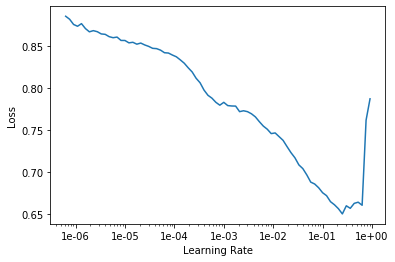

In [9]:
learn.lr_find(); learn.recorder.plot()

In [10]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.367777,0.382597,0.840000,01:38
